## KeepUp Take home Challenge

Benhur Tedros

For this exercise, you will analyze a dataset from Amazon. The data format and a
sample entry are shown on the next page.

A. (Suggested duration: 90 mins)

With the given data for 548552 products, perform exploratory analysis and make
suggestions for further analysis on the following aspects.

1. Trustworthiness of ratings

Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?

2. Category bloat

Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.
For this dataset, quantify the following:

a. Is there redundancy in the categorization? How can it be identified/removed?

b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?

B. (Suggested duration: 30 mins)

Give the number crunching a rest! Just think about these problems.

1. Algorithm thinking

How would build the product categorization from scratch, using similar/co-purchased
information?

2. Product thinking

Now, put on your 'product thinking' hat.

a. Is it a good idea to show users the categorization hierarchy for items?

b. Is it a good idea to show users similar/co-purchased items?

c. Is it a good idea to show users reviews and ratings for items?

d. For each of the above, why? How will you establish the same?

Data entry format:
• Id: Product id (number 0, ..., 548551)
• ASIN: Amazon Standard Identification Number
• title: Name/title of the product
• group: Product group (Book, DVD, Video or Music)
• salesrank: Amazon Salesrank
• similar: ASINs of co-purchased products (people who buy X also buy Y)
• categories: Location in product category hierarchy to which the product belongs
(separated by |, category id in [])
• reviews: Product review information: time, user id, rating, total number of votes on the
review, total number of helpfulness votes (how many people found the review to
be helpful)



In [1]:
# Sample data entry:
# Id: 15
# ASIN: 1559362022
# title: Wake Up and Smell the Coffee
# group: Book
# salesrank: 518927
# similar: 5 1559360968 1559361247 1559360828 1559361018 0743214552
# categories: 3
# |Books[283155]|Subjects[1000]|Literature & Fiction[17]|Drama[2159]|United States[2160]
# |Books[283155]|Subjects[1000]|Arts & Photography[1]|Performing
# Arts[521000]|Theater[2154]|General[2218]
# |Books[283155]|Subjects[1000]|Literature & Fiction[17]|Authors, A-Z[70021]|( B
# )[70023]|Bogosian, Eric[70116]
# reviews: total: 8 downloaded: 8 avg rating: 4
# 2002-5-13 customer: A2IGOA66Y6O8TQ rating: 5 votes: 3 helpful: 2
# 2002-6-17 customer: A2OIN4AUH84KNE rating: 5 votes: 2 helpful: 1
# 2003-1-2 customer: A2HN382JNT1CIU rating: 1 votes: 6 helpful: 1
# 2003-6-7 customer: A2FDJ79LDU4O18 rating: 4 votes: 1 helpful: 1
# 2003-6-27 customer: A39QMV9ZKRJXO5 rating: 4 votes: 1 helpful: 1
# 2004-2-17 customer: AUUVMSTQ1TXDI rating: 1 votes: 2 helpful: 0
# 2004-2-24 customer: A2C5K0QTLL9UAT rating: 5 votes: 2 helpful: 2
# 2004-10-13 customer: A5XYF0Z3UH4HB rating: 5 votes: 1 helpful: 1

In [2]:
# Importing the required libraries

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os
from ggplot import *
import pylab
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from pandas.tools.plotting import scatter_matrix
from sklearn import preprocessing
import statsmodels.api as sm
from operator import itemgetter
from collections import Counter
import heapq

C:\Users\benbahtin\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\benbahtin\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\benbahtin\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Changing the PATH directory
os.chdir('F:\\BENHUR FOLDER\\Data Science Career Track\\Springboard_takehome_challenges\\KeepUp')

In [4]:
# Checking my directory path
os.getcwd()

'F:\\BENHUR FOLDER\\Data Science Career Track\\Springboard_takehome_challenges\\KeepUp'

##### 1. Trustworthiness of ratings
Ratings are susceptible to manipulation, bias etc. What can you say (quantitatively
speaking) about the ratings in this dataset?

In [5]:
reviewNum =[]
with open('amazon-meta.txt',encoding="utf8") as file:
    for L in file:
        s=' '
        seqWord=s.join(L.split())
        words =seqWord.strip().split(' ')
        if words[0] =='reviews:':
            reviewNum.append(float(words[7]))
        
len(reviewNum)

542684

In [6]:
## Put into DataFrame
revDF = pd.DataFrame(reviewNum, columns =['rating'])
revDF.head()

,rating
0,5.0
1,4.5
2,5.0
3,4.0
4,0.0


There are 542684 customer reviews for the different type of products. Let us explore the distribution of the ratings using the density plot 

In [7]:
## Counting the values for each rating
rating = revDF.groupby('rating').size()
rating

rating
0.0    139949
1.0      2732
1.5       837
2.0      4117
2.5      6561
3.0     21227
3.5     34405
4.0     83458
4.5    103563
5.0    145835
dtype: int64

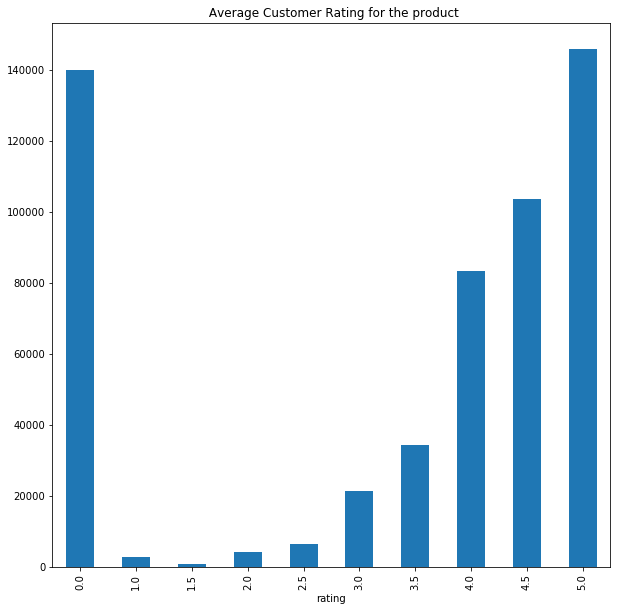

In [8]:
## Density plot for phone
fig, ax = plt.subplots(figsize=(10,10))
rating.plot(kind='bar')
ax.set_title(' Average Customer Rating for the product')

As it is observed in the above figure, the distribution of the ratings is appeared to be asymmetrical(left-skewed distribution). Generally, the trend looks reasonable. Moreover, the number of zero rating seems to be similar to that of five-ratings. This might not be reflective of the genuine zero-rating given for any of the products. It seems that it represents for the number of no-reviews and true zero-reviews. So, this value can be biased.

#### 2. Category bloat
Consider the product group named 'Books'. Each product in this group is associated with
categories. Naturally, with categorization, there are tradeoffs between how broad or
specific the categories must be.

For this dataset, quantify the following:

a. Is there redundancy in the categorization? How can it be identified/removed?

b. Is is possible to reduce the number of categories drastically (say to 10% of existing
categories) by sacrificing relatively few category entries (say close to 10%)?

In the categories section, there might be a redundancy, which may be resulted from the presence of different products with the same categorization or the same product with variety categorization. If that is the case, couple of categories might be redundant. For that purpose, I parsed each row in the file accordingly and identified the unique category for each product with its Amazon ID.

In [9]:
cardict = {}
categ = Counter()
with open('amazon-meta.txt',encoding="utf8") as F:
    catline =False
    for L in F:      
        c =' '
        catword = c.join(L.split())
        wrd =   catword.strip().split(' ')
        if wrd[0] =='ASIN:':
            asnum = wrd[-1]
        if (wrd[0] == 'group:') & (wrd[-1] =='Book'):
            catline =True
            cardict[asnum]=[ ]
        elif (wrd[0] == 'group:') & (wrd[-1] !='Book'):
            catline = False
        if (catline ==True)  & (catword[0:6] =='|Books'):
            a = catword.strip().split('|')[-1]
            cardict[asnum].append(a)
            categ[a] +=1        

In [10]:
## Details of the unique product categories with its Amazon IDs
cardict

{'0827229534': ['Preaching[12368]', 'Sermons[12370]'],
 '0738700797': ['Wicca[12484]', 'Witchcraft[12486]'],
 '0486287785': ['General[5144]'],
 '0842328327': ['New Testament[12159]',
  'Discipleship[12335]',
  'Life Application[572080]',
  'New Testament[572082]',
  'General[572094]'],
 '1577943082': ['Prayerbooks[12470]', 'Business[297488]'],
 '0486220125': ['Photo Essays[2082]',
  'General[4870]',
  'General[4993]',
  'Urban[11296]'],
 '0231118597': ['General[10716]',
  'Criminology[11005]',
  'General[11083]',
  'U.S.[11117]'],
 '1859677800': ['Bread[4197]'],
 '0375709363': ['General[10213]',
  'History & Theory[11086]',
  'Cultural[11235]'],
 '0871318237': ['General[4701]',
  'General[14046]',
  'General[227584]',
  'jp-unknown2[1061350]'],
 '1590770218': ['Herbs, Spices & Condiments[4211]',
  'General[4233]',
  'Diabetic & Sugar-Free[4318]',
  'Low Fat[4323]',
  'General[4628]',
  'Low Carbohydrate[4639]',
  'Low Sugar[4642]',
  'Low-Fat Diet[282849]',
  'Low Carb[10924671]'],
 '0

In [11]:
# Sum of the categories entries utilized to products in the dataset
print(sum([len(x) for x in cardict.values()]))

1286848


This number (1,286848) refers to the total number of subcategories entry for the Book category for each product. When converting the Book subcategories into dataframe, it can be observed that each product is appeared to be contained in a range of 1 and 20 subcategories.

In [12]:
## Converting the dict into dataframe
cardDF = pd.DataFrame.from_dict(cardict, orient='index')

## Renaming the columns
y =[ ('Subcat_' + str(x)) for x in range(0,20)] 
cardDF.columns = y
cardDF.head()


,Subcat_0,Subcat_1,Subcat_2,Subcat_3,Subcat_4,Subcat_5,Subcat_6,Subcat_7,Subcat_8,Subcat_9,Subcat_10,Subcat_11,Subcat_12,Subcat_13,Subcat_14,Subcat_15,Subcat_16,Subcat_17,Subcat_18,Subcat_19
0827229534,Preaching[12368],Sermons[12370],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
0738700797,Wicca[12484],Witchcraft[12486],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
0486287785,General[5144],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
0842328327,New Testament[12159],Discipleship[12335],Life Application[572080],New Testament[572082],General[572094],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1577943082,Prayerbooks[12470],Business[297488],None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [13]:
# Counting the number of each unique categories used in the dataset

print(len(categ))
categ

11316


Counter({'Preaching[12368]': 364,
         'Sermons[12370]': 315,
         'Wicca[12484]': 490,
         'Witchcraft[12486]': 527,
         'General[5144]': 5108,
         'New Testament[12159]': 604,
         'Discipleship[12335]': 343,
         'Life Application[572080]': 90,
         'New Testament[572082]': 1782,
         'General[572094]': 2067,
         'Prayerbooks[12470]': 276,
         'Business[297488]': 270,
         'Photo Essays[2082]': 2748,
         'General[4870]': 1983,
         'General[4993]': 451,
         'Urban[11296]': 513,
         'General[10716]': 760,
         'Criminology[11005]': 868,
         'General[11083]': 7715,
         'U.S.[11117]': 1253,
         'Bread[4197]': 187,
         'General[10213]': 3093,
         'History & Theory[11086]': 1633,
         'Cultural[11235]': 2243,
         'General[4701]': 1404,
         'General[14046]': 508,
         'General[227584]': 389,
         'jp-unknown2[1061350]': 2833,
         'Herbs, Spices & Condiments[4211]

The above result can show the presence of redundancy in the Book categories/subcategories. We have 11,316 unique subcategories applied to each product. It can also be observed that the same categories were used for different products. Also, some catefories seem to contain the same product. For example, the table shows that at least one product looks to be listed in 20 Book subcategories. 

In [14]:
## Checking the products with smallest number of categories
small_cat =heapq.nsmallest(796,categ.items(), key =itemgetter(1))
small_cat 

[('Image Composer[4154]', 1),
 ('Blatty, William P.[5778]', 1),
 ('Block, Lawrence[585764]', 1),
 ('Ravel, Maurice[1572]', 1),
 ('Kadohata, Cynthia[15433]', 1),
 ('Norman, Hilary[565680]', 1),
 ('Gass, William[70277]', 1),
 ('Marsh, Ngaio[585820]', 1),
 ('Greek[3151711]', 1),
 ('Claybourne, Casey[12921]', 1),
 ('General[2521]', 1),
 ('Brand, Dionne[1044144]', 1),
 ('De Chirico, Giorgio[1191]', 1),
 ('Cyclades[67627]', 1),
 ('Benson, E. F.[5705]', 1),
 ('Rodgers, Alan[8721]', 1),
 ('Sleator, William[9039]', 1),
 ('Newport[67531]', 1),
 ('Japan[68034]', 1),
 ('Inheritance[14025831]', 1),
 ('Von Weber[1700]', 1),
 ('Faulkner, Keith[6563]', 1),
 ('( E )[15085]', 1),
 ('The Year I Turned Sixteen[171207]', 1),
 ('Large Print[287401]', 1),
 ('Ondaatje, Michael[1065048]', 1),
 ('Springer, Nancy[9136]', 1),
 ('Bulwer-Lytton, Edward[70143]', 1),
 ('Straczynski, J. Michael[9237]', 1),
 ('Long, Richard[67973]', 1),
 ('Kingsolver, Barbara[287244]', 1),
 ('Lamb, Charlotte[466426]', 1),
 ('Reference 

In [15]:
## percentage of catefories which will be deleted
round((len(heapq.nsmallest(1200,categ.items(), key =itemgetter(1)))/len(categ)) * 100, 4)

10.6045

The above result shows the first 796 categories with lowest occurrence (1x). The total categories we had was 11,316 [ len(categ)]. To get 10% of the categories deleted, I considered the first 1200 categories with the lowest occurrence. This will make up 10.60 % of the existing categories. Let us make new dictionary with the left out categories

In [37]:
## Taking the first element from list of tuples
firstdel = heapq.nsmallest(1200,categ.items(), key =itemgetter(1))
delt_cat = [x[0] for x in firstdel]
delt_cat

['Image Composer[4154]',
 'Blatty, William P.[5778]',
 'Block, Lawrence[585764]',
 'Ravel, Maurice[1572]',
 'Kadohata, Cynthia[15433]',
 'Norman, Hilary[565680]',
 'Gass, William[70277]',
 'Marsh, Ngaio[585820]',
 'Greek[3151711]',
 'Claybourne, Casey[12921]',
 'General[2521]',
 'Brand, Dionne[1044144]',
 'De Chirico, Giorgio[1191]',
 'Cyclades[67627]',
 'Benson, E. F.[5705]',
 'Rodgers, Alan[8721]',
 'Sleator, William[9039]',
 'Newport[67531]',
 'Japan[68034]',
 'Inheritance[14025831]',
 'Von Weber[1700]',
 'Faulkner, Keith[6563]',
 '( E )[15085]',
 'The Year I Turned Sixteen[171207]',
 'Large Print[287401]',
 'Ondaatje, Michael[1065048]',
 'Springer, Nancy[9136]',
 'Bulwer-Lytton, Edward[70143]',
 'Straczynski, J. Michael[9237]',
 'Long, Richard[67973]',
 'Kingsolver, Barbara[287244]',
 'Lamb, Charlotte[466426]',
 'Reference & Development[173226]',
 'Lawrence, D. H.[586014]',
 'Hardcover[285785]',
 'Reinhardt, Ad[1381]',
 'Networking Essentials[3494]',
 'Stuart, Gilbert[1425]',
 'Col

In [54]:
# creating new categories
star={}
for key, value in list(cardict.items()):
    if value not in delt_cat:
        star[key] = []
        star[key].append(value)

### Algorithm thinking

I would utilize the clustering algorithm to build the product categorization from scratch, using similar/co-purchased information. The hierarchical clustering would be the best option. I would start grouping the products which have many similarities into groups, and recursively split into categories down the hierarchical(Top-down approach). This is applied to other products grouped into another cluster.

### Product thinking


I am solemnly support the idea of showing users the categorization hierarchy,  similar/co-purchased items and reviews and ratings for items. Seeing categorization hierarchy of an item can tell the details of the generic type of the product that you are purchasing, though the details might be too much for some people. If users are showed the similar/co-purchased items, they might get an information of an item that they never heard of it. Also, that item might be what the users were looking for. Reviews and ratings may also helpful to the users, though it can be biased. These data can give the users insight of some features (good or bad) contained in the item. 